In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=UserWarning)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier






In [2]:
# Load the dataset (assuming already in df)
df=pd.read_csv("df_model.csv")
# Define the features and target variable

# Shuffle and split the data into features (X) and target (y)
X = df.drop(columns=["loan_status"])  # Feature columns
y = df["loan_status"]  # Target column

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
df.head()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status,person_gender_male,...,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_Yes,person_age_bins_25-30,person_age_bins_30-40,person_age_bins_40-70,credit_score_category_Fair,credit_score_category_Good,credit_score_category_Very Good,credit_score_category_Excellent
0,22.0,71948.0,0,35000.0,16.02,0.49,3.0,561,1,0,...,1,0,0,0,0,0,0,0,0,0
1,21.0,12282.0,0,1000.0,11.14,0.08,2.0,504,0,0,...,0,0,1,0,0,0,0,0,0,0
2,25.0,12438.0,3,5500.0,12.87,0.44,3.0,635,1,0,...,0,0,0,0,0,0,1,0,0,0
3,23.0,79753.0,0,35000.0,15.23,0.44,2.0,675,1,0,...,0,0,0,0,0,0,0,1,0,0
4,24.0,66135.0,1,35000.0,14.27,0.53,4.0,586,1,1,...,0,0,0,0,0,0,1,0,0,0


In [4]:
def entropy(y):
    unique, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return -np.sum(probabilities * np.log2(probabilities))

def conditional_entropy(y, y_left, y_right):
    p_left = len(y_left) / len(y)
    p_right = len(y_right) / len(y)
    return p_left * entropy(y_left) + p_right * entropy(y_right)

def gini(y):
    unique, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return 1 - np.sum(probabilities ** 2)

def gini_split(y, y_left, y_right):
    p_left = len(y_left) / len(y)
    p_right = len(y_right) / len(y)
    return p_left * gini(y_left) + p_right * gini(y_right)

In [5]:

class DecisionTree:
    def __init__(self, max_depth=None, criterion='entropy', min_samples_leaf=1):
        self.max_depth = max_depth
        self.criterion = criterion
        self.min_samples_leaf = min_samples_leaf
        self.tree = None
        self.feature_names = None

    def fit(self, X, y, feature_names=None):
        # Get feature names from X if not provided
        if feature_names is None:
            self.feature_names = X.columns.tolist()  # Use columns of X
        else:
            self.feature_names = feature_names
        self.tree = self._build_tree(X.values, y.values, 0)  # Convert to NumPy arrays

    def _build_tree(self, X, y, depth):
        if len(np.unique(y)) == 1 or (self.max_depth and depth >= self.max_depth) or len(y) < self.min_samples_leaf:
            return np.argmax(np.bincount(y))

        best_split = self._find_best_split(X, y)
        if not best_split:
            return np.argmax(np.bincount(y))

        left_indices, right_indices = best_split['indices']
        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return {'feature': best_split['feature'], 'threshold': best_split['threshold'], 'left': left_subtree, 'right': right_subtree}

    def print_tree(self, node=None, depth=0):
        # Define print_tree function locally
        def print_tree(node, depth=0):
            if isinstance(node, dict):
                feature_name = self.feature_names[node['feature']] if self.feature_names else node['feature']
                print("  " * depth + f"[{feature_name} <= {node['threshold']}]")
                print_tree(node['left'], depth + 1)
                print_tree(node['right'], depth + 1)
            else:
                print("  " * depth + f"[Class: {node}]")
        # Call the local print_tree function to print the actual tree
        if node is None:
            node = self.tree
        print_tree(node, depth)



    def _find_best_split(self, X, y):
        if self.criterion == 'gini':
            return self._best_split_gini(X, y)
        elif self.criterion == 'entropy':
            return self._best_split_entropy(X, y)
        else:
            raise ValueError("Criterion not recognized.")

    def _best_split_gini(self, X, y):
        best_gini = float('inf')
        best_split = None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_indices = np.where(X[:, feature] <= threshold)[0]
                right_indices = np.where(X[:, feature] > threshold)[0]

                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue

                gini = self._gini_index(y[left_indices], y[right_indices])

                if gini < best_gini:
                    best_gini = gini
                    best_split = {'feature': feature, 'threshold': threshold, 'indices': (left_indices, right_indices)}

        return best_split

    def _gini_index(self, left_y, right_y):
        total = len(left_y) + len(right_y)
        if total == 0:
            return 0

        p_left = len(left_y) / total
        p_right = len(right_y) / total

        gini_left = 1 - sum((np.bincount(left_y) / len(left_y)) ** 2) if len(left_y) > 0 else 0
        gini_right = 1 - sum((np.bincount(right_y) / len(right_y)) ** 2) if len(right_y) > 0 else 0

        return p_left * gini_left + p_right * gini_right

    def _best_split_entropy(self, X, y):
        best_entropy = float('inf')
        best_split = None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_indices = np.where(X[:, feature] <= threshold)[0]
                right_indices = np.where(X[:, feature] > threshold)[0]

                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue

                entropy = self._entropy_index(y[left_indices], y[right_indices])

                if entropy < best_entropy:
                    best_entropy = entropy
                    best_split = {'feature': feature, 'threshold': threshold, 'indices': (left_indices, right_indices)}

        return best_split

    def _entropy_index(self, left_y, right_y):
        total = len(left_y) + len(right_y)
        if total == 0:
            return 0

        p_left = len(left_y) / total
        p_right = len(right_y) / total

        entropy_left = -sum((np.bincount(left_y) / len(left_y)) * np.log2(np.bincount(left_y) / len(left_y) + 1e-9)) if len(left_y) > 0 else 0
        entropy_right = -sum((np.bincount(right_y) / len(right_y)) * np.log2(np.bincount(right_y) / len(right_y) + 1e-9)) if len(right_y) > 0 else 0

        return p_left * entropy_left + p_right * entropy_right

    def predict(self, X):
        return np.array([self._predict_sample(sample, self.tree) for sample in X])

    def _predict_sample(self, sample, tree):
        if not isinstance(tree, dict):
            return tree

        feature = tree['feature']
        threshold = tree['threshold']

        # Check if the feature value is numeric
        feature_value = sample[feature]  # Get feature value by name

        # Modified the condition to handle both numeric and categorical features
        if isinstance(feature_value, str):  # Handle categorical features
            if feature_value == threshold:
                return self._predict_sample(sample, tree['left'])
            else:
                return self._predict_sample(sample, tree['right'])
        else:  # Handle numeric features
            if feature_value <= threshold:
                return self._predict_sample(sample, tree['left'])
            else:
                return self._predict_sample(sample, tree['right'])

In [6]:
# Initialize the custom DecisionTree
custom_tree = DecisionTree(max_depth=2, criterion='entropy', min_samples_leaf=5)

# Fit the model to the training data
custom_tree.fit(X_train, y_train)

# Print the decision tree structure
print("Decision Tree Structure:")
custom_tree.print_tree()

# Make predictions on training and testing data
y_train_pred = custom_tree.predict(X_train.values)
y_test_pred = custom_tree.predict(X_test.values)

# Evaluate the model using accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the evaluation results
print("\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")


Decision Tree Structure:
[previous_loan_defaults_on_file_Yes <= 0.0]
  [loan_percent_income <= 0.24]
    [Class: 0]
    [Class: 1]
  [Class: 0]

Model Performance:
Training Accuracy: 0.85
Testing Accuracy: 0.85


In [7]:


# Train and evaluate the custom DecisionTree with Gini
print("\nCustom Decision Tree (Gini):")
custom_tree_gini = DecisionTree(max_depth=5, criterion='gini', min_samples_leaf=5)
custom_tree_gini.fit(X_train, y_train)

# Predict on training and testing data
y_train_pred_gini_custom = custom_tree_gini.predict(X_train.values)
y_test_pred_gini_custom = custom_tree_gini.predict(X_test.values)

# Calculate training and testing accuracy
train_accuracy_gini_custom = accuracy_score(y_train, y_train_pred_gini_custom)
test_accuracy_gini_custom = accuracy_score(y_test, y_test_pred_gini_custom)

# Print accuracy
print(f"Training Accuracy (Gini): {train_accuracy_gini_custom:.2f}")
print(f"Testing Accuracy (Gini): {test_accuracy_gini_custom:.2f}")



# Print textual tree representation (similar to export_text)
print("\nTree Structure (Gini):")
custom_tree_gini.print_tree()


# Train and evaluate the custom DecisionTree with Entropy
print("\nCustom Decision Tree (Entropy):")
custom_tree_entropy = DecisionTree(max_depth=5, criterion='entropy', min_samples_leaf=5)
custom_tree_entropy.fit(X_train, y_train)

# Predict on training and testing data
y_train_pred_entropy_custom = custom_tree_entropy.predict(X_train.values)
y_test_pred_entropy_custom = custom_tree_entropy.predict(X_test.values)

# Calculate training and testing accuracy
train_accuracy_entropy_custom = accuracy_score(y_train, y_train_pred_entropy_custom)
test_accuracy_entropy_custom = accuracy_score(y_test, y_test_pred_entropy_custom)

# Print accuracy
print(f"Training Accuracy (Entropy): {train_accuracy_entropy_custom:.2f}")
print(f"Testing Accuracy (Entropy): {test_accuracy_entropy_custom:.2f}")

# Print textual tree representation (similar to export_text)
print("\nTree Structure (Entropy):")
custom_tree_entropy.print_tree()



Custom Decision Tree (Gini):
Training Accuracy (Gini): 0.91
Testing Accuracy (Gini): 0.91

Tree Structure (Gini):
[previous_loan_defaults_on_file_Yes <= 0.0]
  [loan_percent_income <= 0.24]
    [loan_int_rate <= 13.99]
      [person_income <= 24765.0]
        [loan_percent_income <= 0.12]
          [Class: 0]
          [Class: 1]
        [loan_int_rate <= 11.0]
          [Class: 0]
          [Class: 0]
      [person_home_ownership_OWN <= 0.0]
        [loan_int_rate <= 14.79]
          [Class: 1]
          [Class: 1]
        [person_income <= 23927.0]
          [Class: 1]
          [Class: 0]
    [person_home_ownership_RENT <= 0.0]
      [loan_int_rate <= 14.08]
        [person_income <= 25086.0]
          [Class: 1]
          [Class: 0]
        [loan_intent_MEDICAL <= 0.0]
          [Class: 1]
          [Class: 1]
      [loan_percent_income <= 0.25]
        [person_income <= 94805.0]
          [Class: 1]
          [Class: 0]
        [Class: 1]
  [Class: 0]

Custom Decision Tree (Entro


Scikit-learn Decision Tree (Gini):
Training Accuracy (Gini): 0.85
Testing Accuracy (Gini): 0.85


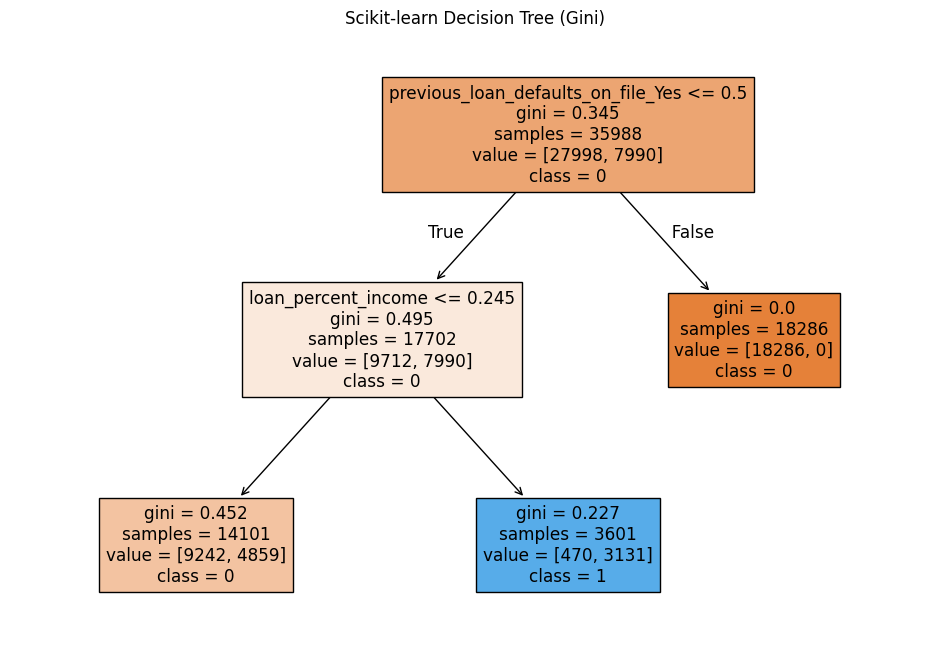


Tree Structure (Gini):
|--- previous_loan_defaults_on_file_Yes <= 0.50
|   |--- loan_percent_income <= 0.24
|   |   |--- class: 0
|   |--- loan_percent_income >  0.24
|   |   |--- class: 1
|--- previous_loan_defaults_on_file_Yes >  0.50
|   |--- class: 0


Scikit-learn Decision Tree (Entropy):
Training Accuracy (Entropy): 0.91
Testing Accuracy (Entropy): 0.91


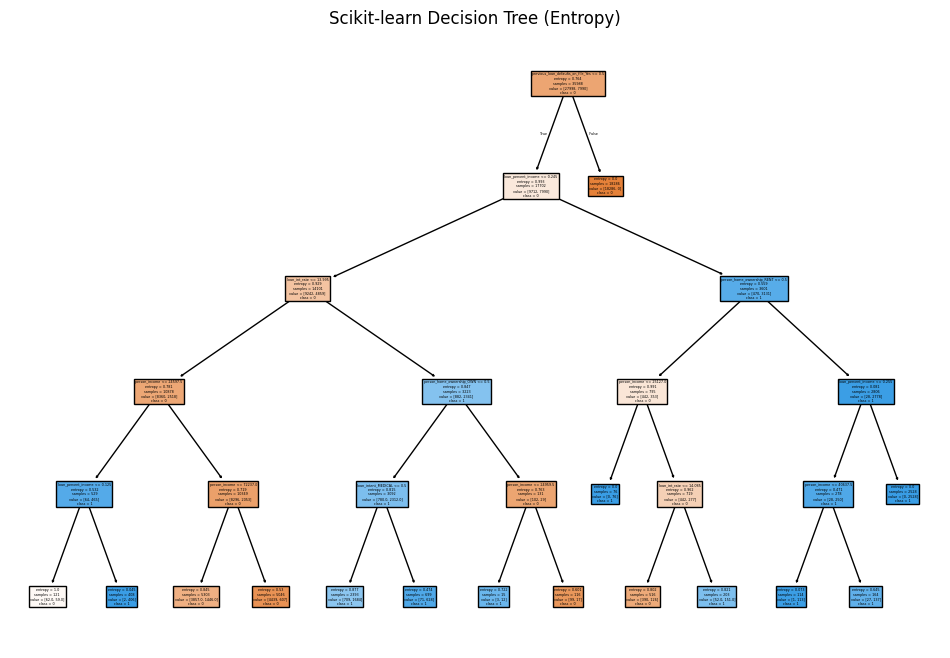


Tree Structure (Entropy):
|--- previous_loan_defaults_on_file_Yes <= 0.50
|   |--- loan_percent_income <= 0.24
|   |   |--- loan_int_rate <= 13.99
|   |   |   |--- person_income <= 24597.50
|   |   |   |   |--- loan_percent_income <= 0.12
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- loan_percent_income >  0.12
|   |   |   |   |   |--- class: 1
|   |   |   |--- person_income >  24597.50
|   |   |   |   |--- person_income <= 72237.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- person_income >  72237.00
|   |   |   |   |   |--- class: 0
|   |   |--- loan_int_rate >  13.99
|   |   |   |--- person_home_ownership_OWN <= 0.50
|   |   |   |   |--- loan_intent_MEDICAL <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- loan_intent_MEDICAL >  0.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- person_home_ownership_OWN >  0.50
|   |   |   |   |--- person_income <= 24959.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- person_income >  24959.50
|   | 

In [8]:


# Train and evaluate Scikit-learn DecisionTree with Gini
print("\nScikit-learn Decision Tree (Gini):")
sklearn_tree_gini = DecisionTreeClassifier(criterion='gini', max_depth=2, min_samples_leaf=5, random_state=42)
sklearn_tree_gini.fit(X_train, y_train)

# Predict on training and testing data
y_train_pred_gini_sklearn = sklearn_tree_gini.predict(X_train)
y_test_pred_gini_sklearn = sklearn_tree_gini.predict(X_test)

# Calculate training and testing accuracy
train_accuracy_gini_sklearn = accuracy_score(y_train, y_train_pred_gini_sklearn)
test_accuracy_gini_sklearn = accuracy_score(y_test, y_test_pred_gini_sklearn)

# Print accuracy
print(f"Training Accuracy (Gini): {train_accuracy_gini_sklearn:.2f}")
print(f"Testing Accuracy (Gini): {test_accuracy_gini_sklearn:.2f}")

# Visualize the tree using plot_tree
plt.figure(figsize=(12, 8))
plot_tree(sklearn_tree_gini,
          feature_names=X_train.columns,
          class_names=sklearn_tree_gini.classes_.astype(str),
          filled=True)
plt.title("Scikit-learn Decision Tree (Gini)")
plt.show()

# Print textual tree representation
print("\nTree Structure (Gini):")
tree_text_gini = export_text(sklearn_tree_gini, feature_names=X_train.columns.tolist())
print(tree_text_gini)

# Train and evaluate Scikit-learn DecisionTree with Entropy
print("\nScikit-learn Decision Tree (Entropy):")
sklearn_tree_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5, random_state=42)
sklearn_tree_entropy.fit(X_train, y_train)

# Predict on training and testing data
y_train_pred_entropy_sklearn = sklearn_tree_entropy.predict(X_train)
y_test_pred_entropy_sklearn = sklearn_tree_entropy.predict(X_test)

# Calculate training and testing accuracy
train_accuracy_entropy_sklearn = accuracy_score(y_train, y_train_pred_entropy_sklearn)
test_accuracy_entropy_sklearn = accuracy_score(y_test, y_test_pred_entropy_sklearn)

# Print accuracy
print(f"Training Accuracy (Entropy): {train_accuracy_entropy_sklearn:.2f}")
print(f"Testing Accuracy (Entropy): {test_accuracy_entropy_sklearn:.2f}")

# Visualize the tree using plot_tree
plt.figure(figsize=(12, 8))
plot_tree(sklearn_tree_entropy,
          feature_names=X_train.columns,
          class_names=sklearn_tree_entropy.classes_.astype(str),
          filled=True)
plt.title("Scikit-learn Decision Tree (Entropy)")
plt.show()

# Print textual tree representation
print("\nTree Structure (Entropy):")
tree_text_entropy = export_text(sklearn_tree_entropy, feature_names=X_train.columns.tolist())
print(tree_text_entropy)


In [9]:

# Calculate accuracies for the results table
results = {
    'Model': ['Custom (Entropy)', 'Custom (Gini)', 'sklearn (Entropy)', 'sklearn (Gini)'],
    'Training Accuracy': [
        train_accuracy_entropy_custom,
        train_accuracy_gini_custom,
        train_accuracy_entropy_sklearn,
        train_accuracy_gini_sklearn
    ],
    'Testing Accuracy': [
        test_accuracy_entropy_custom,
        test_accuracy_gini_custom,
        test_accuracy_entropy_sklearn,
        test_accuracy_gini_sklearn
    ]
}

# Create a pandas DataFrame
results_df = pd.DataFrame(results)

# Display the table
print("\nComparison of Decision Tree Models:")
display(results_df)



Comparison of Decision Tree Models:


,Model,Training Accuracy,Testing Accuracy
0,Custom (Entropy),0.913304,0.914082
1,Custom (Gini),0.913360,0.913749
2,sklearn (Entropy),0.913304,0.914082
3,sklearn (Gini),0.851923,0.849728


Feature Importance

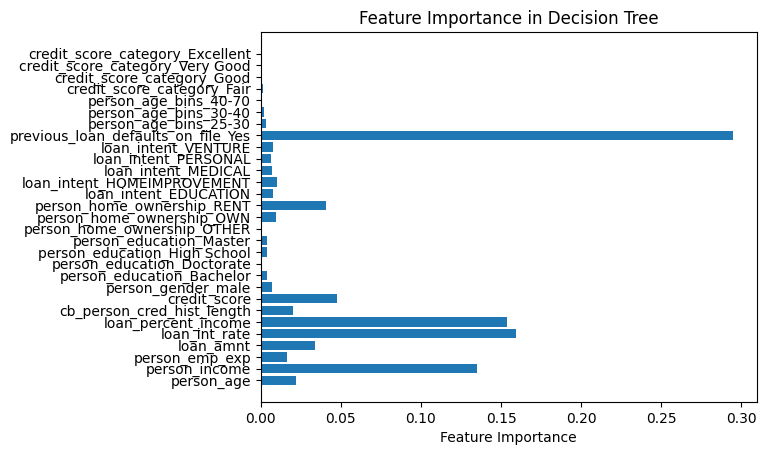

In [10]:
# Fit the model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Get feature importance
feature_importance = dt_model.feature_importances_

# Visualize feature importance
plt.barh(X_train.columns, feature_importance)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Decision Tree')
plt.show()


Metrics for Gini




In [11]:
y_test_pred_gini = sklearn_tree_gini.predict(X_test.values)  # Make sure the model is trained first


# Calculate Precision, Recall, F1 Score
precision_gini = precision_score(y_test, y_test_pred_gini, average='weighted')
recall_gini = recall_score(y_test, y_test_pred_gini, average='weighted')
f1_gini = f1_score(y_test, y_test_pred_gini, average='weighted')

# Print the metrics
print(f"Training Accuracy (Gini): {train_accuracy_gini_sklearn:.2f}")
print(f"Testing Accuracy (Gini): {test_accuracy_gini_sklearn:.2f}")
print(f"Precision (Gini): {precision_gini:.2f}")
print(f"Recall (Gini): {recall_gini:.2f}")
print(f"F1 Score (Gini): {f1_gini:.2f}")




Training Accuracy (Gini): 0.85
Testing Accuracy (Gini): 0.85
Precision (Gini): 0.85
Recall (Gini): 0.85
F1 Score (Gini): 0.83


Metrics for Entropy

In [12]:
y_test_pred_entropy = sklearn_tree_entropy.predict(X_test.values)  # Make sure the model is trained first


# Calculate Precision, Recall, F1 Score for Entropy (sklearn)
precision_entropy_sklearn = precision_score(y_test, y_test_pred_entropy_sklearn, average='weighted')
recall_entropy_sklearn = recall_score(y_test, y_test_pred_entropy_sklearn, average='weighted')
f1_entropy_sklearn = f1_score(y_test, y_test_pred_entropy_sklearn, average='weighted')

# Print the metrics for Entropy (sklearn)
print(f"Training Accuracy (Entropy - sklearn): {train_accuracy_entropy_sklearn:.2f}")
print(f"Testing Accuracy (Entropy - sklearn): {test_accuracy_entropy_sklearn:.2f}")
print(f"Precision (Entropy - sklearn): {precision_entropy_sklearn:.2f}")
print(f"Recall (Entropy - sklearn): {recall_entropy_sklearn:.2f}")
print(f"F1 Score (Entropy - sklearn): {f1_entropy_sklearn:.2f}")


Training Accuracy (Entropy - sklearn): 0.91
Testing Accuracy (Entropy - sklearn): 0.91
Precision (Entropy - sklearn): 0.91
Recall (Entropy - sklearn): 0.91
F1 Score (Entropy - sklearn): 0.91


Confusion Matrix for Gini

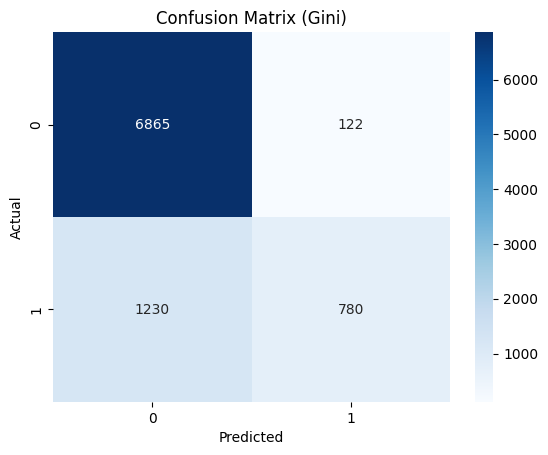

In [13]:
# Confusion Matrix
conf_matrix_gini = confusion_matrix(y_test, y_test_pred_gini)
sns.heatmap(conf_matrix_gini, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix (Gini)")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


Confusion Matrix for Entropy

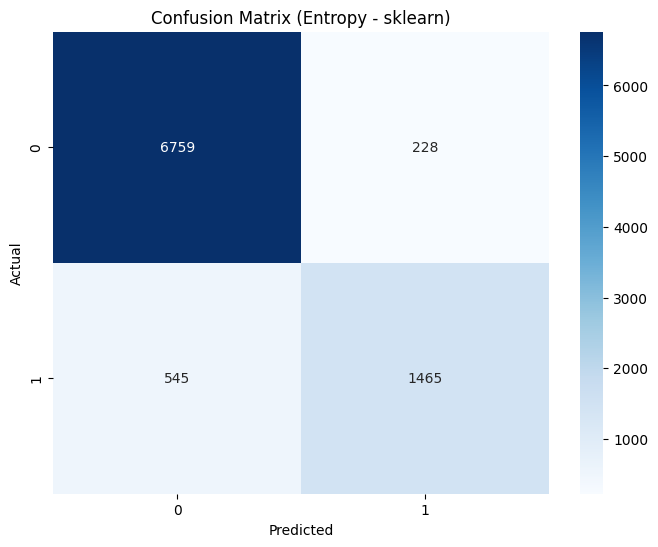

In [14]:


# Confusion Matrix for Entropy (sklearn)
conf_matrix_entropy_sklearn = confusion_matrix(y_test, y_test_pred_entropy_sklearn)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_entropy_sklearn, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix (Entropy - sklearn)")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


Validation Curves: wrt max_depth

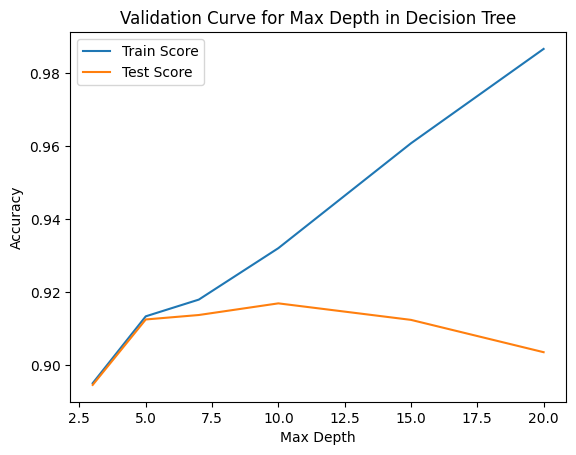

In [15]:

# Use max_depth as the hyperparameter to vary
param_range = [3, 5, 7, 10, 15, 20]
train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(random_state=42),
    X_train, y_train, param_name="max_depth", param_range=param_range, cv=5)

# Plot the validation curve
plt.plot(param_range, train_scores.mean(axis=1), label="Train Score")
plt.plot(param_range, test_scores.mean(axis=1), label="Test Score")
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Validation Curve for Max Depth in Decision Tree')
plt.legend()
plt.show()


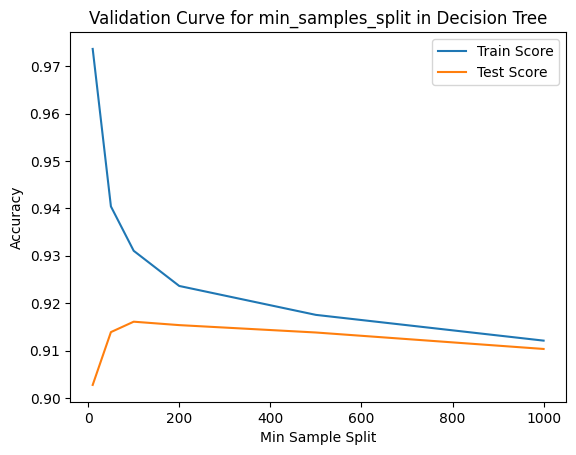

In [16]:


# Define the range of values for min_samples_split
param_range = [10, 50, 100, 200, 500, 1000]

# Compute the validation curve
train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(random_state=42),
    X_train, y_train, param_name="min_samples_split", param_range=param_range, cv=5)

# Plot the validation curve
plt.plot(param_range, train_scores.mean(axis=1), label="Train Score")
plt.plot(param_range, test_scores.mean(axis=1), label="Test Score")
plt.xlabel('Min Sample Split')
plt.ylabel('Accuracy')
plt.title('Validation Curve for min_samples_split in Decision Tree')
plt.legend()
plt.show()


Hyper Paramter Tuning

Best parameters from GridSearchCV: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best Model - Training Accuracy: 0.93
Best Model - Testing Accuracy: 0.92


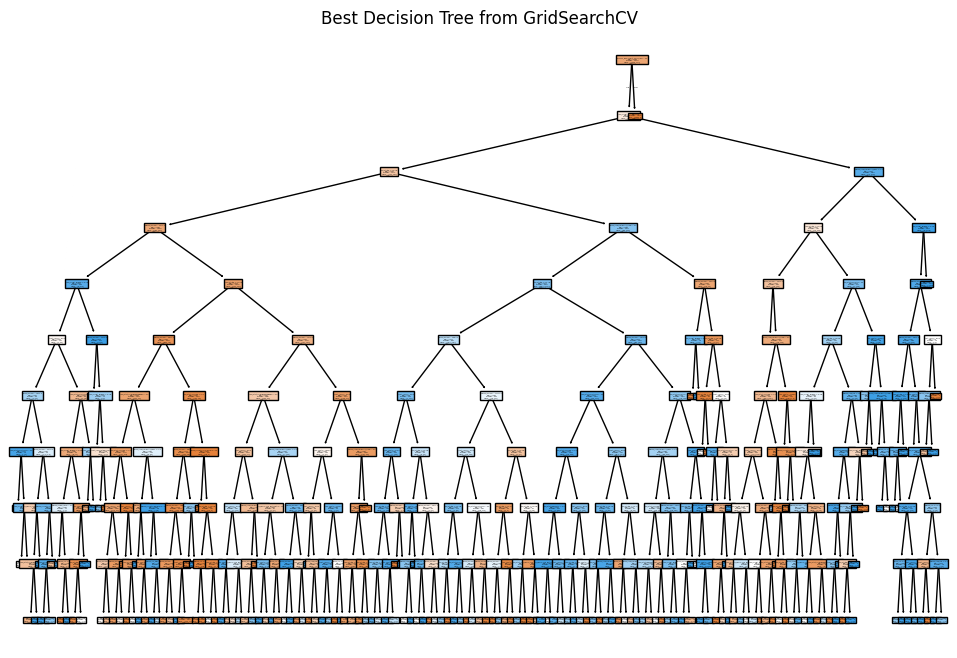

In [17]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters and model from GridSearchCV
print(f"Best parameters from GridSearchCV: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# Predictions with the best model
y_train_pred_best = best_model.predict(X_train)
y_test_pred_best = best_model.predict(X_test)

# Calculate accuracy for the best model
train_accuracy_best = accuracy_score(y_train, y_train_pred_best)
test_accuracy_best = accuracy_score(y_test, y_test_pred_best)

# Print results for the best model
print(f"Best Model - Training Accuracy: {train_accuracy_best:.2f}")
print(f"Best Model - Testing Accuracy: {test_accuracy_best:.2f}")

# Visualize the tree for the best model
plt.figure(figsize=(12, 8))
plot_tree(best_model, filled=True, feature_names=X_train.columns, class_names=best_model.classes_.astype(str))
plt.title("Best Decision Tree from GridSearchCV")
plt.show()


Purning :
tuned to prevent the model from overfitting by cutting branches that don’t improve the model’s accuracy.
python
Copy code



In [18]:
from sklearn.tree import DecisionTreeClassifier

# Use cost-complexity pruning
tree = DecisionTreeClassifier(random_state=42, ccp_alpha=0.01)
tree.fit(X_train, y_train)


DecisionTreeClassifier(ccp_alpha=0.01, random_state=42)

Purned Decision Tree (Cost-Complexity Pruning)

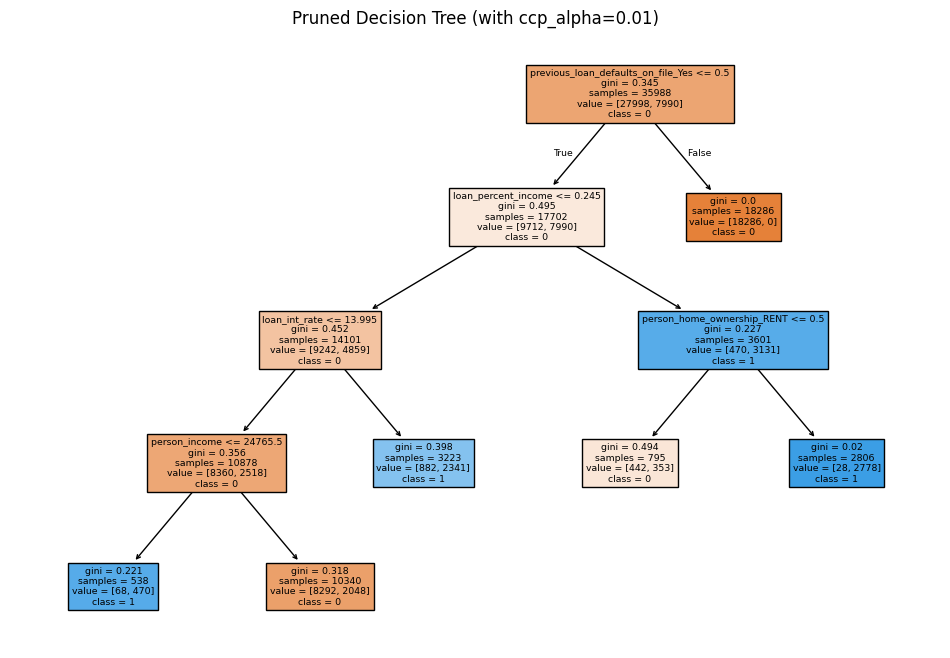

|--- previous_loan_defaults_on_file_Yes <= 0.50
|   |--- loan_percent_income <= 0.24
|   |   |--- loan_int_rate <= 13.99
|   |   |   |--- person_income <= 24765.50
|   |   |   |   |--- class: 1
|   |   |   |--- person_income >  24765.50
|   |   |   |   |--- class: 0
|   |   |--- loan_int_rate >  13.99
|   |   |   |--- class: 1
|   |--- loan_percent_income >  0.24
|   |   |--- person_home_ownership_RENT <= 0.50
|   |   |   |--- class: 0
|   |   |--- person_home_ownership_RENT >  0.50
|   |   |   |--- class: 1
|--- previous_loan_defaults_on_file_Yes >  0.50
|   |--- class: 0



In [19]:


# Fit the pruned tree with ccp_alpha
tree = DecisionTreeClassifier(random_state=42, ccp_alpha=0.01)
tree.fit(X_train, y_train)

# Visualize the pruned decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree, filled=True, feature_names=X_train.columns, class_names=[str(cls) for cls in np.unique(y_train)])
plt.title("Pruned Decision Tree (with ccp_alpha=0.01)")
plt.show()

# Alternatively, print the textual representation of the tree
from sklearn.tree import export_text
tree_text = export_text(tree, feature_names=X_train.columns.tolist())
print(tree_text)


Pruning Evaluation with ccp_alpha

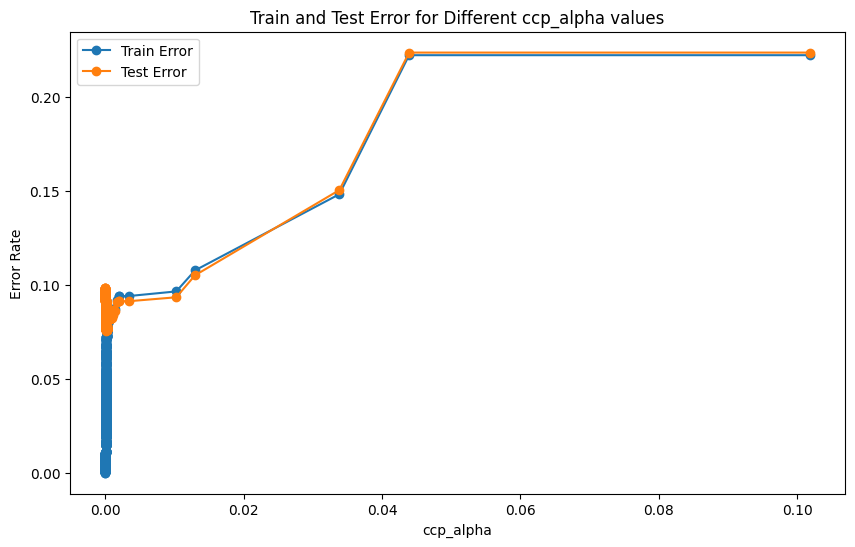

In [20]:
# Create a list of ccp_alpha values
path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Initialize an empty list to store the validation errors
train_errors = []
test_errors = []

# Train decision trees for each ccp_alpha and calculate errors
for ccp_alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    tree.fit(X_train, y_train)

    # Calculate train and test errors
    train_errors.append(1 - tree.score(X_train, y_train))
    test_errors.append(1 - tree.score(X_test, y_test))

# Plot the training and testing errors
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_errors, label="Train Error", marker='o')
plt.plot(ccp_alphas, test_errors, label="Test Error", marker='o')
plt.xlabel("ccp_alpha")
plt.ylabel("Error Rate")
plt.title("Train and Test Error for Different ccp_alpha values")
plt.legend()
plt.show()


AUC-ROC Curve

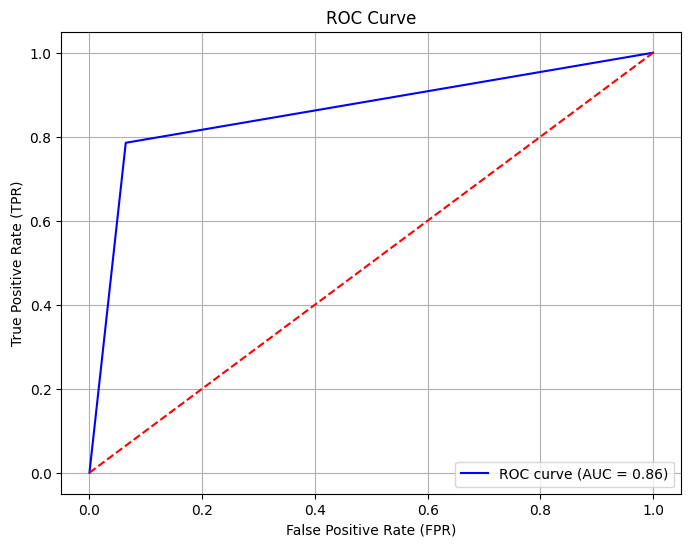

In [21]:


# Assuming you have already split the data into X_train, X_test, y_train, y_test

# Train a decision tree (or any other model)
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict probabilities for the positive class (class=1)
y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Calculate FPR, TPR and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Learning Curve for Decision Tree

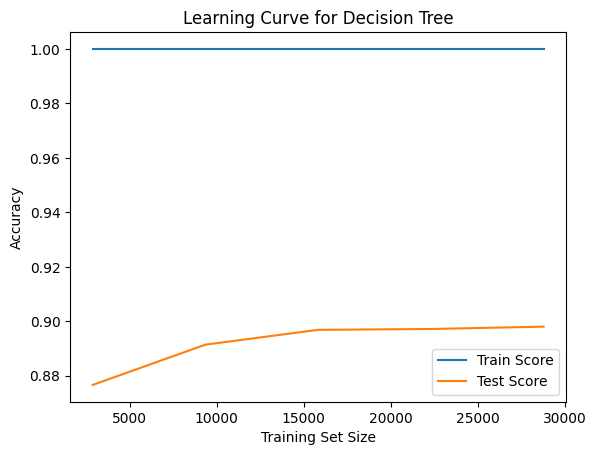

In [22]:

# Get learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    DecisionTreeClassifier(random_state=42),
    X_train, y_train, cv=5, n_jobs=-1)

# Plot the learning curve
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train Score')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Test Score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for Decision Tree')
plt.legend()
plt.show()


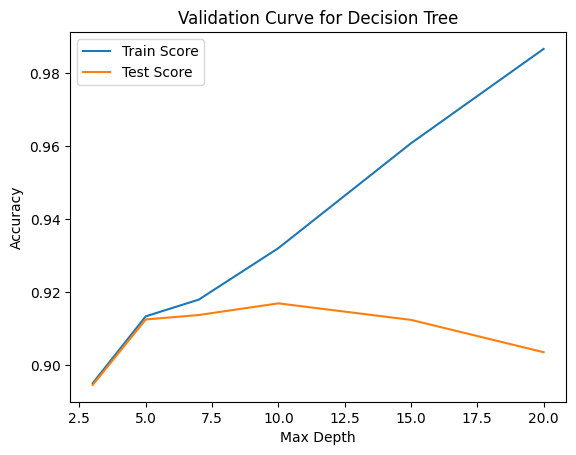

In [23]:
from sklearn.model_selection import validation_curve

# Use max_depth as the hyperparameter to vary
param_range = [3, 5, 7, 10, 15, 20]
train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(random_state=42),
    X_train, y_train, param_name="max_depth", param_range=param_range, cv=5)

# Plot the validation curve
plt.plot(param_range, train_scores.mean(axis=1), label="Train Score")
plt.plot(param_range, test_scores.mean(axis=1), label="Test Score")
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Validation Curve for Decision Tree')
plt.legend()
plt.show()


AdaBost Classifier

Training Accuracy: 0.92
Testing Accuracy: 0.92

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      6987
           1       0.84      0.77      0.81      2010

    accuracy                           0.92      8997
   macro avg       0.89      0.87      0.88      8997
weighted avg       0.91      0.92      0.92      8997



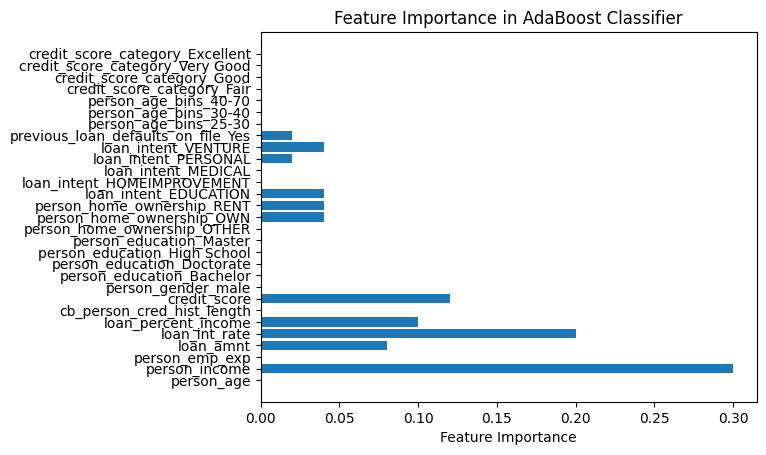

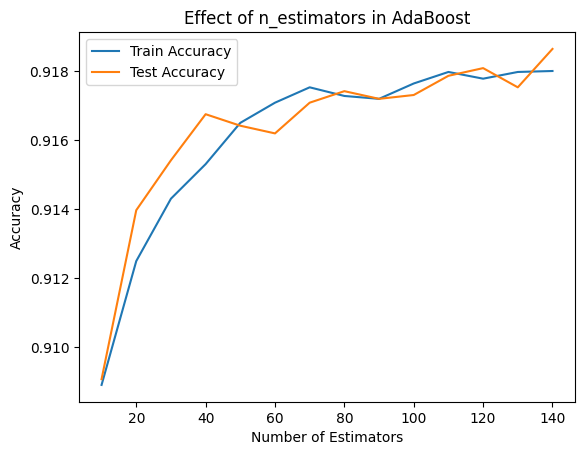

In [ ]:


# Create an AdaBoost Classifier with DecisionTreeClassifier as the base estimator
base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)
adaboost_clf = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, learning_rate=1.0, random_state=42)

# Train the AdaBoost model
adaboost_clf.fit(X_train, y_train)

# Make predictions
y_train_pred = adaboost_clf.predict(X_train)
y_test_pred = adaboost_clf.predict(X_test)

# Evaluate the model
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

# Classification report
print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_test_pred))

# Feature importance
feature_importances = adaboost_clf.feature_importances_
plt.barh(X_train.columns, feature_importances)
plt.xlabel("Feature Importance")
plt.title("Feature Importance in AdaBoost Classifier")
plt.show()

# Plot training vs testing accuracy for varying n_estimators
n_estimators_range = np.arange(10, 150, 10)
train_accuracies = []
test_accuracies = []

for n_estimators in n_estimators_range:
    adaboost_clf = AdaBoostClassifier(estimator=base_estimator, n_estimators=n_estimators, random_state=42)
    adaboost_clf.fit(X_train, y_train)
    train_accuracies.append(adaboost_clf.score(X_train, y_train))
    test_accuracies.append(adaboost_clf.score(X_test, y_test))

plt.plot(n_estimators_range, train_accuracies, label="Train Accuracy")
plt.plot(n_estimators_range, test_accuracies, label="Test Accuracy")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.title("Effect of n_estimators in AdaBoost")
plt.legend()
plt.show()
